# Tous Bénévoles - Volunteering Missions

Date: 2017-06-08
Author: `pascal@bayes.org`

We have access to an XML showing all the volunteering missions gathered by the [Tous Bénévoles](http://wwww.tousbenevoles.org) NGO. The URL is at the address `http://www.tousbenevoles.org/linkedin_webservice/xml/linkedin.xml` and is refreshed regularly.

This notebook analyzes a snapshot to see what kind of data we can expect. Note that there's absolutely no guarantee from our partner that this data will have the same kind of data in the future or even keep the same format.

To reproduce this notebook, first download the data using:
```sh
docker-compose run --rm make data/tous_benevoles.xml
```

Now let's import the Pandas module as well as the file itself.

In [1]:
import os
from os import path

import pandas as pd
import seaborn as _
import xmltodict

DATA_FOLDER = os.getenv('DATA_FOLDER')

dataset = xmltodict.parse(open(path.join(DATA_FOLDER, 'tous_benevoles.xml'), 'rb'))

## Structure

Let's first have a look at the general structure of the XML.

In [2]:
type(dataset)

collections.OrderedDict

In [3]:
dataset.keys()

odict_keys(['jobs'])

In [4]:
type(dataset['jobs'])

collections.OrderedDict

In [5]:
dataset['jobs'].keys()

odict_keys(['job'])

In [6]:
type(dataset['jobs']['job'])

list

In [7]:
len(dataset['jobs']['job'])

2023

So it seems that we have a high level `jobs` element encompassing a list of `job` elements. Let's create a data frame with one "job" per row:

In [8]:
jobs = pd.DataFrame(dataset['jobs']['job'])
jobs.head()

,City,Country,DesiredSkillsAndExperience,JobDescription,JobId,JobTitle,JobType,PostalCode,State,applyURL
0,NICE,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,06000,France,http://www.tousbenevoles.org/trouver-une-missi...
1,MARSEILLE,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,13001,France,http://www.tousbenevoles.org/trouver-une-missi...
2,TOULOUSE,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,31000,France,http://www.tousbenevoles.org/trouver-une-missi...
3,BORDEAUX,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,33000,France,http://www.tousbenevoles.org/trouver-une-missi...
4,MONTPELLIER,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,34000,France,http://www.tousbenevoles.org/trouver-une-missi...


Awesome, we're now ready to dig into the data itself.

## Fields

Let's first check basic stats per column:

In [9]:
jobs.describe()

,City,Country,DesiredSkillsAndExperience,JobDescription,JobId,JobTitle,JobType,PostalCode,State,applyURL
count,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023
unique,350,1,970,1134,1483,1234,1,338,1,1483
top,CERGY,FR,<b>Compétences et savoir-être</b>Ecoute – Comp...,Mission proposée par Auxilia Association Recon...,26255,Bénévolat : Devenir Parrain/Marraine d'un laur...,VOLUNTEER,95,France,http://www.tousbenevoles.org/trouver-une-missi...
freq,203,2023,63,22,11,22,2023,136,2023,11


So not surprisingly some fields are always constant (they are probably there to fit the format of another partner, maybe LinkedIn):
* `Country` is always "FR"
* `JobType` is always "VOLUNTEER"
* `State` is always "France"

### JobId

Now let's check the `JobId` field as it could be used as a unique identifier. However apparently there are multiple rows with the same ID (1966 rows for only 1238 IDs), let's have a quick look at rows that have the same `JobId`. First let's find IDs where there are multiple rows.

In [10]:
jobs[jobs.duplicated(subset='JobId', keep=False)].groupby('JobId').size().head()

JobId
13377    11
18781    11
18782    11
20468    11
22448    11
dtype: int64

It seems that all the JobId that have several rows have exactly 11 rows. After checking with the partner, those 11 cities actually means "available everywhere": as LinkedIn required jobs to have a city, they decided to set it in the main 11 cities.

Let's devise a way to find such jobs quickly:

In [11]:
all_post_codes = jobs.groupby('JobId').PostalCode.apply(lambda codes: ','.join(codes.sort_values()))
all_post_codes[all_post_codes.str.contains(',')].iloc[0]

'06000,13001,31000,33000,34000,35000,44000,59000,67000,69001,75001'

In [12]:
jobs['isAvailableEverywhere'] = jobs.JobId.map(all_post_codes) == '06000,13001,31000,33000,34000,35000,44000,59000,67000,69001,75001'
jobs.sort_values('isAvailableEverywhere', ascending=False).head()

,City,Country,DesiredSkillsAndExperience,JobDescription,JobId,JobTitle,JobType,PostalCode,State,applyURL,isAvailableEverywhere
0,NICE,FR,<b>Compétences et savoir-être</b>\n \nVous ête...,Mission proposée par JobIRL <br /><b>Informati...,35421,Bénévolat : Journalistes sportifs - Partagez ...,VOLUNTEER,06000,France,http://www.tousbenevoles.org/trouver-une-missi...,True
391,NANTES,FR,<b>Compétences et savoir-être</b>Respect de la...,Mission proposée par Auxilia Association Recon...,13377,Bénévolat : Formation par correspondance REMIS...,VOLUNTEER,44000,France,http://www.tousbenevoles.org/trouver-une-missi...,True
393,STRASBOURG,FR,<b>Compétences et savoir-être</b>Respect de la...,Mission proposée par Auxilia Association Recon...,13377,Bénévolat : Formation par correspondance REMIS...,VOLUNTEER,67000,France,http://www.tousbenevoles.org/trouver-une-missi...,True
394,LYON,FR,<b>Compétences et savoir-être</b>Respect de la...,Mission proposée par Auxilia Association Recon...,13377,Bénévolat : Formation par correspondance REMIS...,VOLUNTEER,69001,France,http://www.tousbenevoles.org/trouver-une-missi...,True
395,PARIS,FR,<b>Compétences et savoir-être</b>Respect de la...,Mission proposée par Auxilia Association Recon...,13377,Bénévolat : Formation par correspondance REMIS...,VOLUNTEER,75001,France,http://www.tousbenevoles.org/trouver-une-missi...,True


Now let's take the first ID above and check the stats for the rows corresponding to this `JobId`:

In [13]:
jobs[jobs.JobId == '35421'][list(set(jobs.columns) - {'isAvailableEverywhere'})].describe()

,JobDescription,Country,JobTitle,PostalCode,DesiredSkillsAndExperience,City,JobId,applyURL,JobType,State
count,11,11,11,11,11,11,11,11,11,11
unique,1,1,1,11,1,11,1,1,1,1
top,Mission proposée par JobIRL <br /><b>Informati...,FR,Bénévolat : Journalistes sportifs - Partagez ...,33000,<b>Compétences et savoir-être</b>\n \nVous ête...,MONTPELLIER,35421,http://www.tousbenevoles.org/trouver-une-missi...,VOLUNTEER,France
freq,11,11,11,1,11,1,11,11,11,11


Cool, for this one at least, it seems that all the fields are in common except for the `City` and the `PostalCode` as if the same job was available in several cities and as such was cut in several rows to fit a dedicated format. Let's make sure it's indeed the case with all the IDs with multiple rows:

In [14]:
all_fields_but_geo = set(jobs.columns) - set(('City', 'PostalCode'))
jobs.drop_duplicates(subset=all_fields_but_geo)\
    .groupby('JobId')\
    .size()\
    .value_counts()

1    1483
dtype: int64

Alright, our assumption was true, when the same job ID is used on multiple row it's only to specify several cities for the same job.

# Geographic Distribution

Now let's look at the City field in order to get the distribution of jobs (= volunteering missions) in various cities.

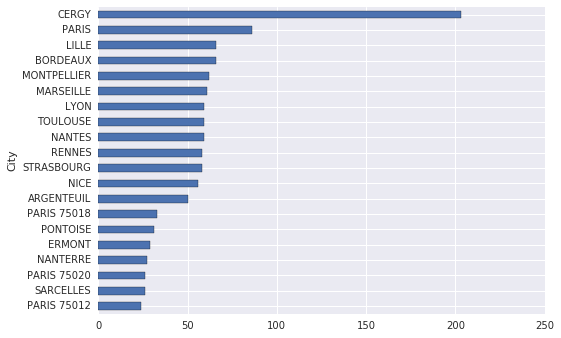

In [15]:
jobs.groupby('City').size().sort_values(ascending=False).head(20).sort_values().plot(kind='barh');

Hmmm, this is not at all what we expected:
* the city of Cergy has the most missions.
* the first cities are the big ones, but Paris doesn't stand out that much. Looking a bit further it seems to be because Paris is divided by various postcodes.

After asking the partner: they are especially active in the 95 département, near Cergy.

What about Paris?

In [16]:
jobs[jobs.City.str.startswith('PARIS')].City.value_counts()

PARIS          86
PARIS 75018    33
PARIS 75020    26
PARIS 75012    24
PARIS 75014    19
PARIS 75015    17
PARIS 75019    15
PARIS 75011    14
PARIS 13       13
PARIS 75005    13
PARIS 75009    12
PARIS 18       10
PARIS 20        9
PARIS 75013     9
PARIS 75007     8
PARIS 75010     7
PARIS 15        7
PARIS 75017     6
PARIS 12        6
PARIS 75006     6
PARIS 10        5
PARIS 75002     5
PARIS 19        4
PARIS 75008     3
PARIS 7         3
PARIS 75116     3
PARIS 5         2
PARIS 6         2
PARIS 2         2
PARIS 17        2
PARIS 11        2
PARIS 14        2
PARIS 75004     1
PARIS 75016     1
PARIS 16        1
PARIS 9         1
Name: City, dtype: int64

It seems clear that the city name is not harmonized, at least for Paris: sometimes it's the whole city, sometimes it's only an arrondissement, and sometimes the city name contains the postcode itself.

Let's do a quick check if it's the case for other cities:

In [17]:
jobs[(jobs.City.str.contains('[A-Z] [0-9]')) & ~(jobs.City.str.startswith('PARIS'))].City.value_counts()

MARSEILLE 13008          5
LYON 69007               5
LYON 69002               5
AMIENS 80090             3
LYON 69006               3
LYON 7                   2
MULHOUSE 68200           2
TOULOUSE 31400           2
MARSEILLE 13005          2
ST DENIS 93210           2
MARSEILLE 13010          2
MARSEILLE 2              1
MONTPELLIER 34080        1
BORDEAUX 33300           1
ORLEANS 45100            1
TOULOUSE 31500           1
MARSEILLE 13002          1
MARSEILLE 13007          1
AIX EN PROVENCE 13290    1
MARSEILLE 13014          1
MARSEILLE 4              1
AIX EN PROVENCE 13090    1
MARSEILLE 13013          1
GRENOBLE 38100           1
ARLES 13200              1
MARSEILLE 5              1
LYON 69003               1
Name: City, dtype: int64

Obviously this is the case with the other cities that have multiple arrondissements, but it seems to be also the case with cities that have multiple postal codes for the same city (like `Toulouse` which is `31000` but use `TOULOUSE 31400` and `TOULOUSE 31500`, or `Orléans` which is `45000` but also use `ORLEANS 45100`).

This might be a problem, as in our application we do not keep track of which part of the city someone is: even for Paris, Marseille & Lyon this info is only kept in the name for display, we do not have any distinguishing ID for user target job's location.

Let's clean it up and only keep the city's name:

In [18]:
jobs['clean_city'] = jobs['City'].str.replace(' \d+', '')
jobs.clean_city.value_counts().head()

PARIS        379
CERGY        203
MARSEILLE     77
LYON          75
BORDEAUX      67
Name: clean_city, dtype: int64

Now that it's cleaned, let's see the distribution by cities:

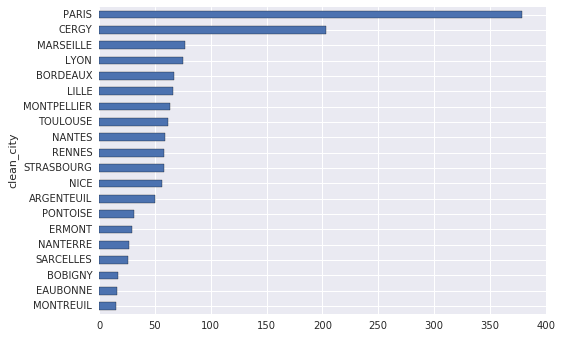

In [19]:
jobs[jobs.City != 'LEFFRINCKOUCKE'].\
    groupby('clean_city').size().sort_values(ascending=False).\
    head(20).sort_values().plot(kind='barh');

This is kind of what we would expect.

Let's plot now the number of cities with enough missions to be shown:

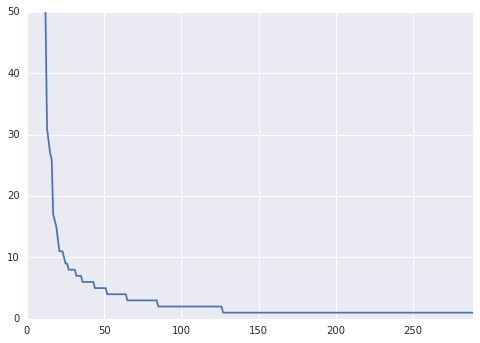

In [20]:
jobs[jobs.City != 'LEFFRINCKOUCKE']\
    .groupby('clean_city').size().sort_values(ascending=False)\
    .reset_index(drop=True)\
    .plot(ylim=(0, 50));  # 50 is taken from the chart above.

There are missions in about 300 cities, but more than half of them have only one mission and only ~60 cities have at least 3 missions. I suggest we show the missions in a person's cities but also the one in their département if there are less than 3 in the city.

So let's check the distribution at the département level:

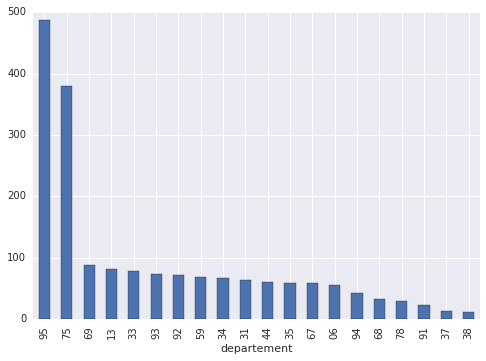

In [21]:
jobs['departement'] = jobs.PostalCode.str[:2]
jobs_per_departement = jobs[jobs.City != 'LEFFRINCKOUCKE'].groupby('departement').size().sort_values(ascending=False)
jobs_per_departement.head(20).plot(kind='bar');

Not surprisingly we get the départment with top cities (Paris, Lyon, Marseille) as the first ones, and then in `95` where the organization did some dedicated work.

Let's now check the coverage over all départements:

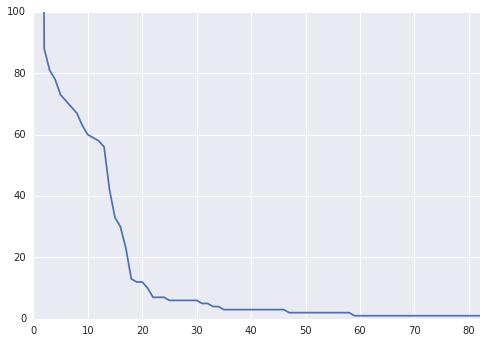

In [22]:
jobs_per_departement\
    .reset_index(drop=True)\
    .plot(ylim=(0, 100));  # 100 was taken from the chart above.

Missions are not in all départements (there are 100 départements) and most of them have less than 20 missions. However there are more than 15 départements where there are 40 different missions and still a very large number of départements with 3 missions or more:

In [23]:
sum(jobs_per_departement >= 3)

47

## Missing Fields

Now we would also like to extract from each row, the organization that is proposing the mission a nice title and a description. Let's see if we can find that in the `JobDescription` and `JobTitle` fields:

In [24]:
jobs[['JobDescription', 'JobTitle']].drop_duplicates().head().transpose()

,0,11,22,33,44
JobDescription,Mission proposée par JobIRL <br /><b>Informati...,Mission proposée par JobIRL <br /><b>Informati...,Mission proposée par JobIRL <br /><b>Informati...,Mission proposée par JobIRL <br /><b>Informati...,Mission proposée par JobIRL <br /><b>Informati...
JobTitle,Bénévolat : Journalistes sportifs - Partagez ...,Bénévolat : Journalistes reporters d'images - ...,Bénévolat : Astronaute - Partagez votre expér...,Bénévolat : Techniciens qualité alimentaire - ...,Bénévolat : Ingénieur du son - Partagez votre...


It seems that `JobDescription` always starts with "Mission proposée par" and that `JobTitle` always start with "Bénévolat : ". Let's make sure it's the case:

In [25]:
jobs.JobDescription.str.startswith('Mission proposée par ').value_counts()

True    2023
Name: JobDescription, dtype: int64

In [26]:
jobs.JobTitle.str.startswith('Bénévolat : ').value_counts()

True    2023
Name: JobTitle, dtype: int64

Bingo, let's extract those constant strings and clean up the description and title:

In [27]:
jobs['title'] = jobs.JobTitle.str.replace('^Bénévolat : ', '')
jobs['proposed_by'] = jobs.JobDescription.str.extract('^Mission proposée par ([^<]+)<br />', expand=False)
jobs['description'] = jobs.JobDescription.str.replace('^Mission proposée par ([^<]+)<br />', '')
jobs[['title', 'proposed_by', 'description']].drop_duplicates().head()

,title,proposed_by,description
0,Journalistes sportifs - Partagez votre expéri...,JobIRL,<b>Informations complémentaires</b>Vous êtes j...
11,Journalistes reporters d'images - Partagez vo...,JobIRL,<b>Informations complémentaires</b>Vous êtes j...
22,Astronaute - Partagez votre expérience profes...,JobIRL,<b>Informations complémentaires</b>Vous êtes a...
33,Techniciens qualité alimentaire - Partagez vo...,JobIRL,<b>Informations complémentaires</b>Vous êtes t...
44,Ingénieur du son - Partagez votre expérience ...,JobIRL,<b>Informations complémentaires</b>\n \nVous ê...


Nice title, nice "proposed by" field. The description could probably be cleaned a bit more:

In [28]:
jobs.description.str.startswith('<b>Informations complémentaires</b>').value_counts()

True    2023
Name: description, dtype: int64

As suspected it always continue with "Informations complémentaires", let's strip it as well.

In [29]:
jobs['description'] = jobs.description.str.replace('^<b>Informations complémentaires</b>', '').str.strip()
jobs[['title', 'proposed_by', 'description']].drop_duplicates().head()

,title,proposed_by,description
0,Journalistes sportifs - Partagez votre expéri...,JobIRL,"Vous êtes journaliste sportif, vous aimez votr..."
11,Journalistes reporters d'images - Partagez vo...,JobIRL,"Vous êtes journaliste reporter d'images, vous ..."
22,Astronaute - Partagez votre expérience profes...,JobIRL,"Vous êtes astronaute, vous aimez votre métier ..."
33,Techniciens qualité alimentaire - Partagez vo...,JobIRL,"Vous êtes technicien qualité alimentaire, vous..."
44,Ingénieur du son - Partagez votre expérience ...,JobIRL,"Vous êtes ingénieur du son, vous aimez votre m..."


OK, this is good enough for now!

# Conclusion

The data from `Tous Bénévoles` is quite clean and contains enough data to show an advice card pushing 3 different missions for about 60 cities, if we restrict it to city, or half of the départements if we extend to missions in the same département.

As a fallback there seems to be some missions available over the whole country.

However when using the data: be careful with the `City` field as it might sometimes contain more than just the city.

The original fields are not immediately usable, to get a clean title, the description or the organization that suggested the mission in the first place, you'll need some additional cleanup.